# San Francisco Crime Rates Analysis

In [1]:
# Set directory
import os 
os.chdir('data2')

In [12]:
# Import packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import folium
from IPython.display import HTML
from pandas.api.types import CategoricalDtype
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# Load data
# train_zips = pd.read_csv('train_zips.csv')
# test_zips = pd.read_csv('test_zips.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

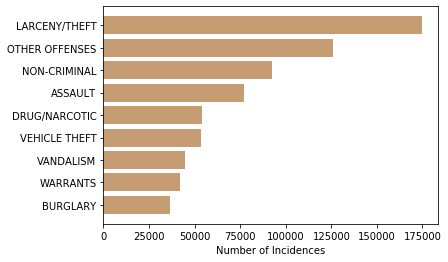

In [5]:
# Get 10 most common crimes
most_common_cat = train['Category'].value_counts()[0:9].sort_values()
most_common_cat.values


categs = most_common_cat.index
y_pos = np.arange(len(categs))
counts = most_common_cat.values

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, categs)
plt.xlabel('Number of Incidences')

plt.show()

In [6]:
by_zone = train.apply(pd.Series.value_counts).reset_index()

# Load SF data
!wget --quiet https://cocl.us/sanfran_geojson -O sf_neighborhoods.json
sf_zones = r'sf_neighborhoods.json'

SF_COORDINATES = (37.76, -122.45)
 

# Create an empty map zoomed in on San Francisco
sf_crime_map = folium.Map(location=SF_COORDINATES, zoom_start=12)


sf_crime_map.choropleth(
    geo_data=sf_zones,
    data=by_zone,
    columns=['index', 'PdDistrict'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='San Fransisco Crime by Neighborhood'
)

sf_crime_map

/Users/ritakurban/anaconda3/envs/evamodels/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Text(69.0, 0.5, '')

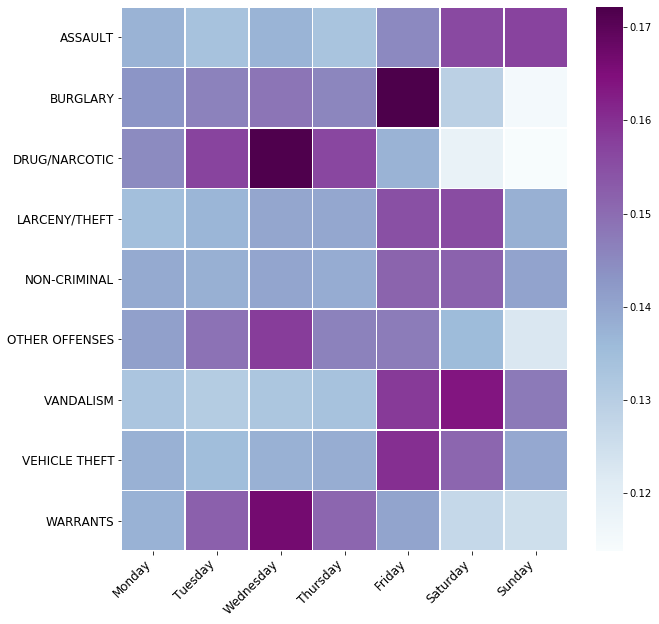

In [7]:
# Extract the most common crimes from the data
most_commons = train[train['Category'].apply(lambda x: x in categs)]

# Build a cross table to get the number of each crime type per day of week
cat_per_week_common = pd.crosstab(most_commons['Category'], most_commons['DayOfWeek']) 
# Calculate percentages of crimes
cat_per_week_common = cat_per_week_common.div(cat_per_week_common.sum(axis=1), axis=0)
# Rearrange columns
cat_per_week_common = cat_per_week_common[['Monday', 
                                           'Tuesday', 'Wednesday', 
                                           'Thursday', 'Friday', 
                                           'Saturday','Sunday']]
# Transform into a heat map
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cat_per_week_common,
                 cmap="BuPu", linewidths=.5)
plt.xticks(fontsize=12,rotation=45,ha='right')
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")

In [8]:
np.unique(train.Category)

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

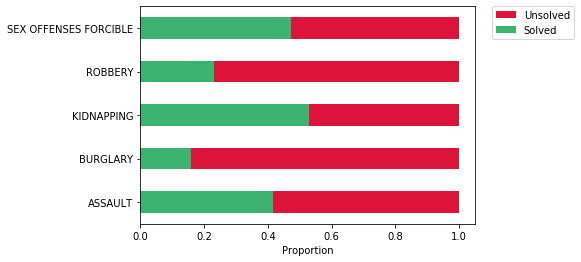

In [10]:
# Pick crime types of interest
violent = train[train.Category.isin(['ASSAULT', 'BURGLARY',
                                       'KIDNAPPING', 'ROBBERY',  
                                       'SEX OFFENSES FORCIBLE'])].copy()
# Create Arrest variable
violent['Arrest'] = np.where(violent['Resolution'].isin(['NONE', 'NOT PROSECUTED']), 0,1)

# Calculate counts
arrest_counts = violent['Category'][violent.Arrest==1].value_counts()[0:9]
total_counts = violent['Category'].value_counts()[0:9]
arrest_counts = arrest_counts/(total_counts).sort_index()
total_counts = total_counts/(total_counts).sort_index()

# Plot values
total_counts.plot.barh(color='crimson', label= 'Unsolved')
arrest_counts.plot.barh(color='mediumseagreen', label='Solved')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Proportion')
plt.show()

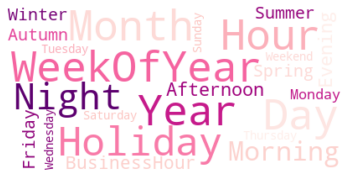

In [13]:
text = 'Year, Month, Day, Hour, WeekOfYear, Holiday, Night, Morning, Afternoon, Evening, BusinessHour, Spring, Summer, Autumn, Winter, Friday, Monday, Saturday,Sunday, Thursday, Tuesday, Wednesday, Weekend'

# Create and generate a word cloud image:
wordcloud = WordCloud(colormap='RdPu',max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear', cmap='PuRd')
plt.axis("off")
plt.show()

In [14]:
#Data Exploration

# Show data
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [15]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


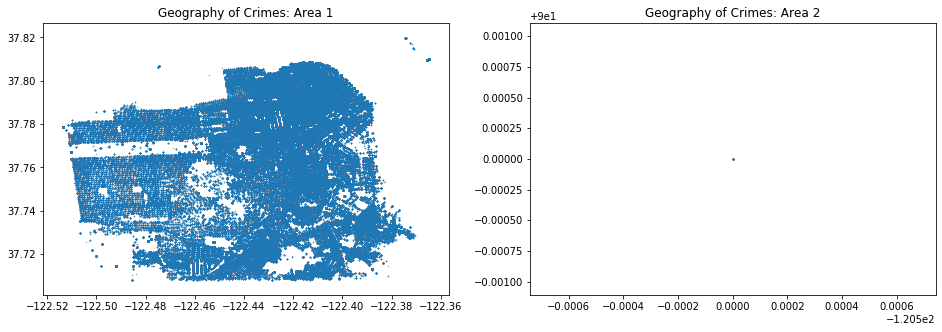

In [16]:
# Show two different areas
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.scatter(train.X[train.Y<90],train.Y[train.Y<90], alpha=0.5, s=0.3)
ax1.set_title('Geography of Crimes: Area 1')
ax2.scatter(train.X[train.Y>=90],train.Y[train.Y>=90], alpha=0.5, s=0.3)
ax2.set_title('Geography of Crimes: Area 2')
plt.show()

We found it suspicious that all the outlier coordinates were the same, so looked them up on the map and they happen to be somewhere in the Atlantic Ocean. Since the police departments associated with these coordinates differ, it is highly likely that they are used as when the location of the crime is unknown. 

In [17]:
# Use the most frequent zipcode to impute outliers
train.loc[train['Y']>=90,'zipcode'] = 94103
test.loc[test['Y']>=90,'zipcode'] = 94103
train_zips = pd.concat([train_zips, train[train.Y>=90]], ignore_index = True).drop('Unnamed: 0',axis=1)
test_zips = pd.concat([test_zips, test[test.Y>=90]], ignore_index = True).drop('Unnamed: 0',axis=1)

NameError: name 'train_zips' is not defined

In [18]:
# Target variable exploration
train.Category.unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [19]:
print('Percentage of other offenses: %.2f' % 
      (train.Category[train.Category.values=='OTHER OFFENSES'].count()/len(train)))

Percentage of other offenses: 0.14


### Feature Engineering

In [20]:
# Check columns that exist in both datasets
[val if val in test.columns.values else '' for val in train.columns.values]

['Dates',
 '',
 '',
 'DayOfWeek',
 'PdDistrict',
 '',
 'Address',
 'X',
 'Y',
 'zipcode']

In [21]:

#Perhaps population density? Pull from uszipcode but by coordinates
#NOTE: false simple zipcode means 450MB download but so many more columns! :) 
#EDIT: not simple zipcode takes too long to lookup. Get full list of zips first, then use it.
search = SearchEngine(simple_zipcode=True)

In [22]:
# Zip helper functions
def zip_lookup(lat,lon):
    '''
    Add zipcode and population density based on coordinates. 
    X is longitude, Y is latitude.
    '''
    try:
        for zipcode in search.by_coordinates(lat,lon,radius=5,returns=1):
            zp = zipcode.to_dict()
        return zp['zipcode']
    except:
        return None
    

def zip_dict(zp):
    '''
    Pull in features for a single zipcode.
    '''
    search = SearchEngine(simple_zipcode=False)
    d = search.by_zipcode(str(zp)).to_dict()
    d['zipcode'] = zp
    return d


def clean_dtypes(df):
    ''' 
    Clean zipcode data by extracting useful from the dictionaries.
    '''
    cols_to_drop = []
    df['zipcode'] = df['zipcode'].astype(int)
    for i,dtype in enumerate(df.dtypes):
        if dtype == 'object':
            cols_to_drop.append(i)
            #for each category in the list of dicts, add a column for that category
            for j,dic in enumerate(df.iloc[0,i][0]['values']):
                df[dic['x']] = [val[0]['values'][j]['y'] if val != None else None for val in df.iloc[:,i].values]
    df.drop(df.columns[cols_to_drop],axis=1,inplace=True)
    return df

In [23]:
# Feature Engineers
def zip_engineer(df, feats):
    '''
    Extract spatial features from data.
    '''
    df['zipcode'] = df.loc[:,['X','Y']].apply(lambda x: zip_lookup(x[1], x[0]), axis=1).astype(int)
    # Extract features from zipcodes
    zip_df = pd.DataFrame({'zipcode': df['zipcode'].dropna().unique()})
    zip_df = pd.DataFrame.from_records(zip_df.loc[:,'zipcode'].apply(lambda x: zip_dict(x)))
    # Keep specified columns and clean dtypes
    zip_df = clean_dtypes(zip_df[feats])
    # Merge zip reference with original df on zipcode
    merged = pd.merge(df, zip_df, how='left',on='zipcode')
    return merged


def time_engineer(data):
    '''
    Extract temporal features from dates.
    '''
    # Turn strings into timestamp objects
    data.Dates = pd.to_datetime(data.Dates)

    # Extract years, months, times of the day, and weeks of year
    data['Year'] = data['Dates'].dt.year
    data['Month'] = data['Dates'].dt.month
    data['Day'] = data['Dates'].dt.day
    data['Hour'] = data['Dates'].dt.hour
    data['WeekOfYear'] = data['Dates'].dt.weekofyear

    # Add a dummy for public holidays
    cal = calendar()
    holidays = cal.holidays(start=data['Dates'].min(), end=data['Dates'].max())
    data['Holiday'] = data['Dates'].dt.date.astype('datetime64').isin(holidays)

    # Add times of a day
    data['Night'] = np.where((data['Hour']< 6), 1, 0)
    data['Morning'] = np.where((data['Hour']>=6) & (data['Hour']<12), 1, 0)
    data['Afternoon'] = np.where((data['Hour']>= 12) & (data['Hour']<18), 1, 0)
    data['Evening'] = np.where((data['Hour']>= 18) & (data['Hour']<24), 1, 0)
    data['BusinessHour'] = np.where((data['Hour']>= 8) & (data['Hour']<18), 1, 0)

    # Add seasons
    data['Spring'] = np.where((data['Month']>=3) & (data['Month']<6), 1, 0)
    data['Summer'] = np.where((data['Month']>=6) & (data['Month']<9), 1, 0)
    data['Autumn'] = np.where((data['Month']>=9) & (data['Month']<12), 1, 0)
    data['Winter'] = np.where((data['Month']<=2) | (data['Month']==12), 1, 0)

    # Encode weekdays
    data_dummies = pd.get_dummies(data['DayOfWeek'])
    data = pd.concat([data, data_dummies], axis=1)

    # Create a dummy for weekends
    data['Weekend'] = np.where((data['DayOfWeek']=='Saturday') & (data['DayOfWeek']=='Sunday'), 1, 0)

    # Encode districts
    data_dummies = pd.get_dummies(data['PdDistrict'])
    data = pd.concat([data, data_dummies], axis=1)
    data = data.drop(columns=['PdDistrict'])
    return data

In [24]:
# Define zip features we want to keep
feats = ['zipcode','population_by_race','population_by_age',
         'families_vs_singles','median_household_income',
         'housing_occupancy','employment_status',
         'educational_attainment_for_population_25_and_over',
         'source_of_earnings','school_enrollment_age_3_to_17']

In [25]:
# Engineer training data
train_eng = zip_engineer(train, feats)
train_eng = time_engineer(train_eng)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
# Engineer testing data
test_eng = zip_engineer(test,feats)
test_eng = time_engineer(test_eng)

In [ ]:
train = pd.read_csv('train_eng_full.csv')
test = pd.read_csv('test_eng_full.csv')

### Model selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [ ]:
data.Holiday = data.Holiday.astype('bool')

In [ ]:
data.columns

In [ ]:
data = data.dropna(axis=1)

In [ ]:
len(data.columns)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the target 
cat_le = LabelEncoder()
cat_le.fit(data['Category'].unique())
data['Category'] = cat_le.transform(data['Category'])
y = data['Category']

# Save our mapping
decoder = dict(zip(cat_le.transform(cat_le.classes_), cat_le.classes_))

In [ ]:

features = data.drop(columns=(['Category','Address', 'Unnamed: 0', 'Unnamed: 0.1', 
                               'Unnamed: 0.1.1', 'Dates', 'Descript', 'DayOfWeek','Resolution'  ]))
# print(features.dtypes)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

In [ ]:
col_mask=X_train.isnull().any(axis=0) 

row_mask=X_train.isnull().any(axis=1)

X_train.loc[row_mask,col_mask]

In [ ]:
models = [LogisticRegression]#, RandomForestClassifier, KNeighborsClassifier]

def run_model(model):
    model = model()
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
#     print('Accuracy of classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))
#     return(model.log_loss(X_test, y_test))
    return (log_loss(y_test, y_preds))
    
results = [run_model(model) for model in models]